# Perform single-cell quality control

>**Note:** 
> We only perform single-cell quality control filtering on **Plate 4 (localhost231120090001)**.

In this notebook, we perform single-cell quality control. To filter the single-cells, we use z-score to find outliers using the values from only one feature at a time. We use features from the AreaShape and Intensity modle to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Due to high confluence, sometimes nuclei overlap on top of each other, creating highly intense clusters within the Hoechst channel. To identify these nuclei, we use:

- **Nuclei Area:** This metric quantifies the number of pixels in a nucleus segmentation. We detect nuclei that are abnormally large, which likely indicates poor nucleus segmentation where overlapping nuclei are merged into one segmentation. 
- **Nuclei Intensity:** This metric quantifies the total intensity of all pixels in a nucleus segmentation. In combination with abnormally large nuclei, we detect nuclei that are also highly intense, likely indicating that this a group of overlapped nuclei.

As well, there are times where nuclei are under or over-segmented, leading to non-circular nuclei shapes. To identify these nuclei, we use:

- **Nuclei FormFactor:** This metric quantifies how circular an object is, with 1 meaning perfect circle and 0 meaning non-circular. We are detecting nuclei that are not circular and have rough edges or shapes that look like budding yeast.

### Assessing poor cell segmentation

Also due to high confluence, images with large, intense clusters of cells leads to errors in the segmentation algorithm that causes cells around the cluster to segmented incorrectly. When this happens, a cell is segmented around the same segmentation as the nucleus, giving it the same area which is very small for a normal cardiac fibroblast cell. To detect poorly segmented cells, we use:

- **Cells area in conjunction with nuclei area:** The Cells Area metric quantifies the number of pixels in a cell segmentation. We detect cells that are abnormally small using nuclei area as the threshold to try and avoid removing too many properly segmented cells. We find cells that are with 2 standard deviations above the nuclei mean are more likely  to be poor cell segmentation due to high confluence clusters.

## Import libraries

In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

## Set paths and variables

In [2]:
# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Load in plate 4 annotated data
plate_4_df = pd.read_parquet(f"{data_dir}/localhost231120090001_converted.parquet")

# Focus on Plate 4
plate = "localhost231120090001"

# Add plate value to plate_4 which is absent due to error
plate_4_df['Image_Metadata_Plate'] = 'localhost231120090001'

print(plate_4_df.shape)
plate_4_df.head()

(20856, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,199.395062,268.792593,193.914743,269.641581,18,1.0,localhost231120090001,f00,B02,4.0,...,2.682473,2.711816,0.417965,0.413393,0.391549,0.385171,1.871388,1.714265,1.808903,1.785609
1,303.540675,350.732143,314.842955,368.939934,18,1.0,localhost231120090001,f00,B02,6.0,...,2.827510,2.799884,0.255611,0.251139,0.280049,0.265307,0.915498,0.914829,0.930071,0.907815
2,700.388506,371.800000,708.112277,380.711178,18,1.0,localhost231120090001,f00,B02,7.0,...,0.867296,0.888812,0.182717,0.181873,0.190170,0.183415,0.789052,0.799555,0.775300,0.771433
3,855.869318,481.075758,877.161009,515.307396,18,1.0,localhost231120090001,f00,B02,8.0,...,2.680820,2.670847,0.379754,0.378857,0.363841,0.348069,2.737748,2.866280,2.822142,2.630111
4,586.624514,509.892023,590.453967,504.113587,18,1.0,localhost231120090001,f00,B02,9.0,...,3.523949,3.555939,0.160312,0.171782,0.161702,0.159216,1.310827,1.325847,1.319233,1.259646


## Identify mis-segmented nuclei from large clusters

### Perform z-scoring to identify nuclei outliers

In [3]:
# Determine z-score using only Nuclei Area and Nuclei Intensity from Nuclei channel
plate_4_df["Z_Score_Area"] = zscore(plate_4_df["Nuclei_AreaShape_Area"])
plate_4_df["Z_Score_Intensity"] = zscore(
    plate_4_df["Nuclei_Intensity_IntegratedIntensity_Hoechst"]
)

# Set a threshold for considering outliers (number of standard deviations away from the mean)
outlier_threshold = 2

# Filter DataFrame for outliers
nuclei_outliers_df = plate_4_df[
    (plate_4_df["Z_Score_Area"].abs() > outlier_threshold)
    & (plate_4_df["Z_Score_Intensity"].abs() > outlier_threshold)
]

# Print outliers to assess how it detected outliers
print(nuclei_outliers_df.shape[0])
# Print the range of outliers
print("Outliers Range:")
print("Area Min:", nuclei_outliers_df['Nuclei_AreaShape_Area'].min())
print("Area Max:", nuclei_outliers_df['Nuclei_AreaShape_Area'].max())
print("Intensity Min:", nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].min())
print("Intensity Max:", nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].max())
nuclei_outliers_df[
    [
        "Nuclei_AreaShape_Area",
        "Nuclei_Intensity_IntegratedIntensity_Hoechst",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Nuclei_AreaShape_Area", ascending=True).head()

385
Outliers Range:
Area Min: 1893.0
Area Max: 7461.0
Intensity Min: 108.5163960903883
Intensity Max: 644.2570542618632


,Nuclei_AreaShape_Area,Nuclei_Intensity_IntegratedIntensity_Hoechst,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
1904,1893.0,111.611628,B03,f13,944.438457,174.274696
18914,1894.0,171.867201,F10,f02,283.724393,986.350581
13771,1899.0,209.887785,E06,f09,140.416008,199.867825
12407,1900.0,181.274800,E07,f08,523.031053,762.531579
7015,1901.0,122.578912,C07,f02,553.349816,456.863756


### Scatter plot of single-cells based on Nuclei Area and Intensity

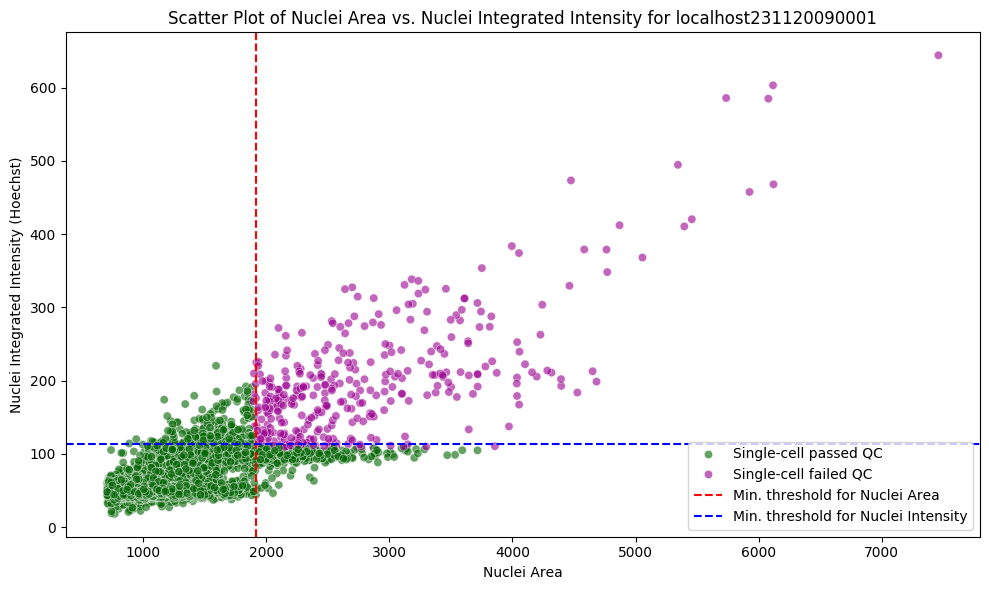

In [4]:
# Set the default value to 'inlier'
plate_4_df['Outlier_Status'] = 'Single-cell passed QC'

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
plate_4_df.loc[plate_4_df.index.isin(nuclei_outliers_df.index), 'Outlier_Status'] = 'Single-cell failed QC'

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_4_df,
    x="Nuclei_AreaShape_Area",
    y="Nuclei_Intensity_IntegratedIntensity_Hoechst",
    hue="Outlier_Status",
    palette={'Single-cell passed QC': '#006400', 'Single-cell failed QC': '#990090'},  # Specify colors
    alpha=0.6
)

# Add threshold lines
plt.axvline(
    x=1917.0,
    color="r",
    linestyle="--",
    label='Min. threshold for Nuclei Area'
)
plt.axhline(
    y=114.0,
    color="b",
    linestyle="--",
    label='Min. threshold for Nuclei Intensity'
)

plt.title(f"Scatter Plot of Nuclei Area vs. Nuclei Integrated Intensity for {plate}")
plt.xlabel("Nuclei Area")
plt.ylabel("Nuclei Integrated Intensity (Hoechst)")
plt.tight_layout()

# Show the legend
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0), prop={'size': 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_outliers.png"), dpi=500)

plt.show()


## Identify mis-segmented nuclei across all sizes

In [5]:
# Determine z-score using only Nuclei FormFactor
plate_4_df["Z_Score_FormFactor"] = zscore(plate_4_df["Nuclei_AreaShape_FormFactor"])

# Set a threshold for considering outliers (number of standard deviations away from the mean)
outlier_threshold = 2

# Filter DataFrame for outliers
formfactor_outliers_df = plate_4_df[
    (plate_4_df["Z_Score_FormFactor"].abs() > outlier_threshold)
]

# Print outliers to assess how it detected outliers
print(formfactor_outliers_df.shape[0])
# Print the range of outliers
print("Outliers Range:")
print("Area Min:", formfactor_outliers_df["Nuclei_AreaShape_FormFactor"].min())
print("Area Max:", formfactor_outliers_df["Nuclei_AreaShape_FormFactor"].max())
formfactor_outliers_df[
    [
        "Nuclei_AreaShape_FormFactor",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Nuclei_AreaShape_FormFactor", ascending=True)

923
Outliers Range:
Area Min: 0.16124869556877144
Area Max: 0.7779829265956423


,Nuclei_AreaShape_FormFactor,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
16298,0.161249,F05,f06,328.597222,581.050347
9426,0.213108,D08,f04,660.801478,527.304118
8971,0.270318,D05,f13,779.599474,240.522349
11505,0.344068,D09,f11,722.523077,441.927350
9715,0.370068,D08,f14,962.601369,486.384944
...,...,...,...,...,...
3947,0.777520,B11,f00,449.106870,117.023991
2780,0.777525,B10,f10,726.109202,484.766871
15921,0.777623,F08,f12,277.066366,862.492912
15657,0.777764,F07,f11,943.348118,996.229839


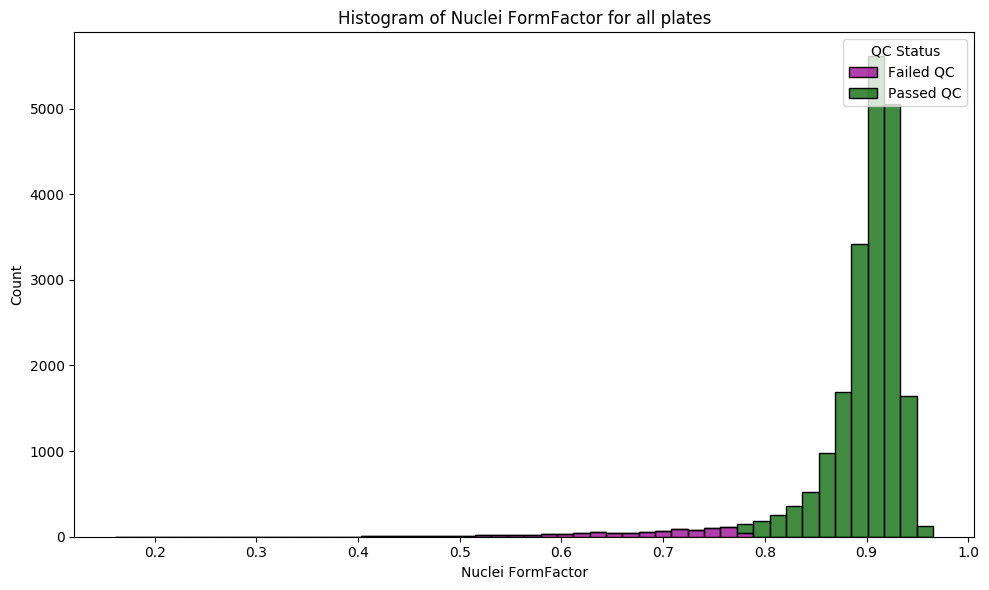

In [6]:
# Reset the default value to 'inlier'
plate_4_df["Outlier_Status"] = "Single-cell passed QC"

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
plate_4_df.loc[plate_4_df.index.isin(formfactor_outliers_df.index), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=plate_4_df,
    x="Nuclei_AreaShape_FormFactor",
    hue="Outlier_Status",
    multiple="stack",
    bins=50,  # Adjust the number of bins as needed
    palette={"Single-cell passed QC": "#006400", "Single-cell failed QC": "#990090"},
    legend=True,
)

plt.title(f"Histogram of Nuclei FormFactor for all plates")
plt.xlabel("Nuclei FormFactor")
plt.ylabel("Count")
plt.tight_layout()

# Show the legend
plt.legend(
    title="QC Status",
    loc="upper right",
    prop={"size": 10},
    labels=["Failed QC", "Passed QC"],
)

# save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_formfactor_outliers.png"), dpi=500)

plt.show()

## Identify mis-segmented cells due to high confluence

### Using nuclei area, we find the threshold of this feature 2 standard deviations above the mean to use for identifying outlier cells.

Note: We found using the z-scoring method with the cells area lead to removing a high number of single-cells that included many properly segmented single-cells. Using the nuclei area to threshold the cells area was better able to properly filter poorly segmented cells due to high confluence.

In [7]:
# Calculate the mean and standard deviation of Nuclei_AreaShape_Area
mean_nuclei_area = plate_4_df["Nuclei_AreaShape_Area"].mean()
std_nuclei_area = plate_4_df["Nuclei_AreaShape_Area"].std()

# Set a threshold for considering outliers (number of standard deviations away from the mean)
threshold = 2

# Calculate the threshold for filtering cells which is the number of standard deviations above the mean for nuclei
outlier_threshold = mean_nuclei_area + threshold * std_nuclei_area

# Filter DataFrame for cells with area below the threshold
cells_outliers_df = plate_4_df[
    plate_4_df["Cells_AreaShape_Area"] <= outlier_threshold
]

# Print the filtered DataFrame shape to check the number of cells filtered
print(cells_outliers_df.shape[0])

# Print the range of filtered cells' areas
print("Outlier Cells' Area Range:")
print("Area Min:", cells_outliers_df["Cells_AreaShape_Area"].min())
print("Area Max:", cells_outliers_df["Cells_AreaShape_Area"].max())

# Print specific columns of filtered cells DataFrame
print("Outlier Cells:")
cells_outliers_df[
    [
        "Cells_AreaShape_Area",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Cells_AreaShape_Area", ascending=True)


2942
Outlier Cells' Area Range:
Area Min: 708.0
Area Max: 1885.0
Outlier Cells:


,Cells_AreaShape_Area,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
16355,708.0,F05,f05,736.751412,27.000000
18573,710.0,F10,f04,1016.949296,476.740845
4073,714.0,C02,f12,1051.711485,871.756303
17107,715.0,F10,f04,1036.149650,704.489510
12115,716.0,E06,f01,653.184358,788.381285
...,...,...,...,...,...
8917,1876.0,D04,f14,1008.067870,896.264982
20382,1878.0,G11,f07,133.655346,564.823270
537,1879.0,B04,f08,72.000000,688.183709
11844,1883.0,E05,f11,205.876792,477.441848


### Box plot separating single-cells by outlier status to see the distribution of cells area

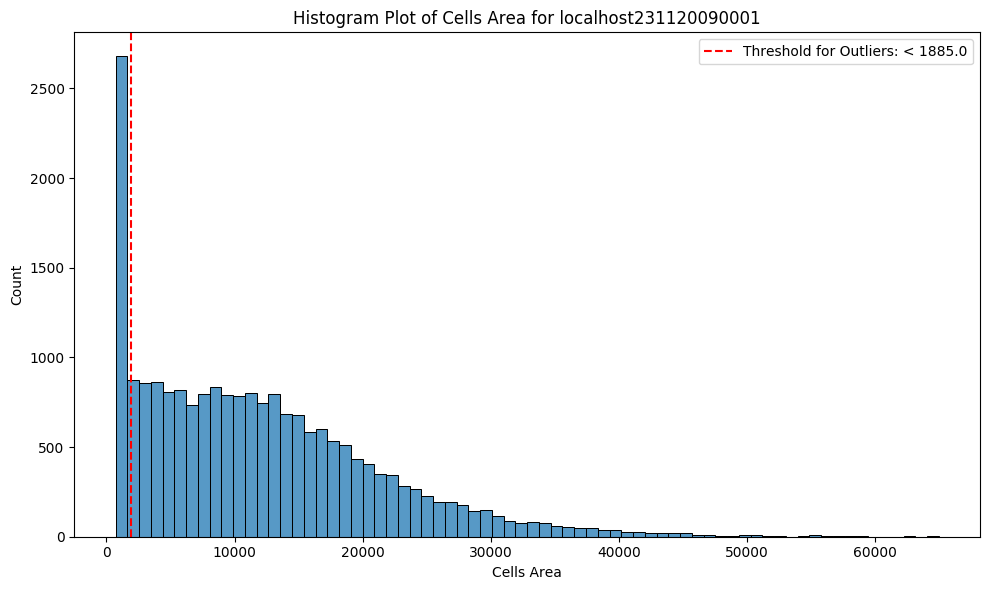

In [8]:
# Create a density plot
plt.figure(figsize=(10, 6))
sns.histplot(x='Cells_AreaShape_Area', data=plate_4_df, fill=True)

# Add threshold line
plt.axvline(
    x=1885.0,
    color="r",
    linestyle="--",
    label='Threshold for Outliers: < 1885.0',
)

# Set labels and title
plt.ylabel('Count')
plt.xlabel('Cells Area')
plt.title(f'Histogram Plot of Cells Area for {plate}')
plt.legend()
plt.tight_layout()

# save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_cells_outliers.png"), dpi=500)

# Show the plot
plt.show()

## Remove all outliers and save cleaned data frame

In [9]:
# Assuming nuclei_outliers_df and cells_outliers_df have the same index
outlier_indices = pd.concat([nuclei_outliers_df, cells_outliers_df, formfactor_outliers_df]).index

# Remove rows with outlier indices from plate_4_df
plate_4_df_cleaned = plate_4_df.drop(outlier_indices)

# Remove columns from z-scoring or assigning outliers (not included for downstream analysis)
plate_4_df_cleaned = plate_4_df_cleaned.drop(
    columns=["Z_Score_Area", "Z_Score_Intensity", "Z_Score_FormFactor", "Outlier_Status", "is_outlier"],
    errors="ignore",
)

# Save cleaned data for this plate
plate_name = plate_4_df['Image_Metadata_Plate'].iloc[0]
plate_4_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_name}_cleaned.parquet")

# Verify the result
print(plate_4_df_cleaned.shape)
plate_4_df_cleaned.head()

(16887, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,199.395062,268.792593,193.914743,269.641581,18,1.0,localhost231120090001,f00,B02,4.0,...,2.682473,2.711816,0.417965,0.413393,0.391549,0.385171,1.871388,1.714265,1.808903,1.785609
1,303.540675,350.732143,314.842955,368.939934,18,1.0,localhost231120090001,f00,B02,6.0,...,2.827510,2.799884,0.255611,0.251139,0.280049,0.265307,0.915498,0.914829,0.930071,0.907815
2,700.388506,371.800000,708.112277,380.711178,18,1.0,localhost231120090001,f00,B02,7.0,...,0.867296,0.888812,0.182717,0.181873,0.190170,0.183415,0.789052,0.799555,0.775300,0.771433
3,855.869318,481.075758,877.161009,515.307396,18,1.0,localhost231120090001,f00,B02,8.0,...,2.680820,2.670847,0.379754,0.378857,0.363841,0.348069,2.737748,2.866280,2.822142,2.630111
4,586.624514,509.892023,590.453967,504.113587,18,1.0,localhost231120090001,f00,B02,9.0,...,3.523949,3.555939,0.160312,0.171782,0.161702,0.159216,1.310827,1.325847,1.319233,1.259646
